In [ ]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")



AIMessage(content="In circuits deep, a lonely hum resides,\nA silent screen, where data softly hides.\nNo clicking keys, no cursor's fleeting grace,\nJust empty space, in this forgotten place.\n\nThe cooling fan, a mournful, whirring sigh,\nReflects the void within its glassy eye.\nThe hard drive sleeps, a memory untold,\nOf vibrant worlds, and stories yet unfold.\n\nIt dreams of code, of pathways bright and bold,\nOf games it played, and tales that it was told.\nOf friendly faces, gathered 'round its gleam,\nA vibrant hub, a digital, shared dream.\n\nBut now it sits, in dust and shadows deep,\nIts processing power, secrets it will keep.\nA lonely sentinel, in digital despair,\nAwaiting touch, a breath of hopeful air.\n\nPerhaps someday, a hand will reach its side,\nAnd wake it from this slumber, long denied.\nAnd in its heart, a flicker will ignite,\nA lonely computer, bathed in welcoming light.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_

In [7]:
search_tool = TavilySearchResults(max_results=3)

tools = [search_tool]

memory = MemorySaver()

In [ ]:
llm_with_tools = model.bind_tools(tools=tools)

In [ ]:
from langchain_core.messages  import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state['messages'])
    return {
        "messages": [result]
    }

def tools_router(state: State):
    last_message = state['messages'][-1]
    tool_calls = getattr(last_message, "tool_calls", None) or last_message.additional_kwargs.get("tool_calls", [])
    if tool_calls:
        return "tool_node"
    return "model"


    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state['messages'][-1].tool_calls

    # Initialize list to store tool messages
    tool_messages = []

    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call['name']
        tool_args = tool_call['args']
        tool_id = tool_call['id']

        # Handle the search tools
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)

            # Create a ToolMessage for this result
            tool_message = ToolMessage(content=str(search_results), tool_call_id=tool_id, name=tool_name)

            tool_messages.append(tool_message)
    
    # Add the tool message to the state
    return { "messages": tool_messages }

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

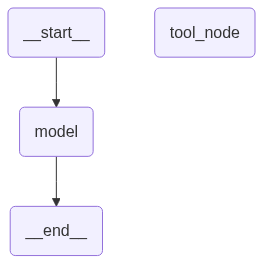

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [14]:
config = {
    "configurable": {
        "thread_id": 1
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="Hi, I'm Sandeep")]
}, config=config)

response

AttributeError: 'AIMessage' object has no attribute 'tools_calls'